# Readmission Prediction Pipeline

This notebook combines data generation, preprocessing, model training, evaluation, and model saving for hospital readmission prediction. Follow the steps below to run the full pipeline interactively.

## 1. Load Data from CSV

Read the synthetic patient dataset using pandas.

In [1]:
import pandas as pd
import numpy as np

# Load synthetic patient data
DATA_PATH = '../data/synthetic_patient_data.csv'
df = pd.read_csv(DATA_PATH)
df.head()

,age,gender,admission_type,length_of_stay,num_lab_procedures,num_medications,diagnosis_code,readmitted
0,69,Male,Elective,2,15,11,N18,1
1,32,Female,Emergency,4,22,12,M79,0
2,89,Female,Emergency,8,27,18,I10,1
3,78,Male,Emergency,1,27,15,E11,0
4,38,Male,Emergency,8,17,9,F32,0


## 2. Clean and Preprocess Data

Handle missing values, normalize or scale features, and encode categorical variables.

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Example: Impute missing values for numeric columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

imputer = SimpleImputer(strategy='mean')
df[numeric_features] = imputer.fit_transform(df[numeric_features])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and join encoded
preprocessed_df = df.drop(columns=categorical_features).join(encoded_df)
preprocessed_df.head()

,age,length_of_stay,num_lab_procedures,num_medications,readmitted,gender_Female,gender_Male,gender_Other,admission_type_Elective,admission_type_Emergency,admission_type_Urgent,diagnosis_code_E11,diagnosis_code_F32,diagnosis_code_I10,diagnosis_code_I50,diagnosis_code_J44,diagnosis_code_K21,diagnosis_code_M79,diagnosis_code_N18
0,69.0,2.0,15.0,11.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32.0,4.0,22.0,12.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,89.0,8.0,27.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,78.0,1.0,27.0,15.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.0,8.0,17.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Feature Engineering

Create new features or transform existing ones to improve model performance (e.g., comorbidity score).

In [5]:
# Example: Create a comorbidity score feature
if 'comorbidity_1' in preprocessed_df.columns and 'comorbidity_2' in preprocessed_df.columns:
    preprocessed_df['comorbidity_score'] = preprocessed_df[['comorbidity_1', 'comorbidity_2']].sum(axis=1)

preprocessed_df.head()

,age,length_of_stay,num_lab_procedures,num_medications,readmitted,gender_Female,gender_Male,gender_Other,admission_type_Elective,admission_type_Emergency,admission_type_Urgent,diagnosis_code_E11,diagnosis_code_F32,diagnosis_code_I10,diagnosis_code_I50,diagnosis_code_J44,diagnosis_code_K21,diagnosis_code_M79,diagnosis_code_N18
0,69.0,2.0,15.0,11.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32.0,4.0,22.0,12.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,89.0,8.0,27.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,78.0,1.0,27.0,15.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.0,8.0,17.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Train/Test Split

Split the dataset into training and testing sets using scikit-learn.

In [6]:
from sklearn.model_selection import train_test_split

# Assume target column is 'readmitted'
X = preprocessed_df.drop(columns=['readmitted']) if 'readmitted' in preprocessed_df.columns else preprocessed_df
Y = preprocessed_df['readmitted'] if 'readmitted' in preprocessed_df.columns else None

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (800, 18), Test shape: (200, 18)


## 5. Model Training

Train a machine learning model (e.g., logistic regression) on the training data.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.6350


## 6. Model Evaluation

Evaluate the trained model using metrics such as accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.71       116
         1.0       0.59      0.44      0.50        84

    accuracy                           0.64       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.63      0.64      0.62       200



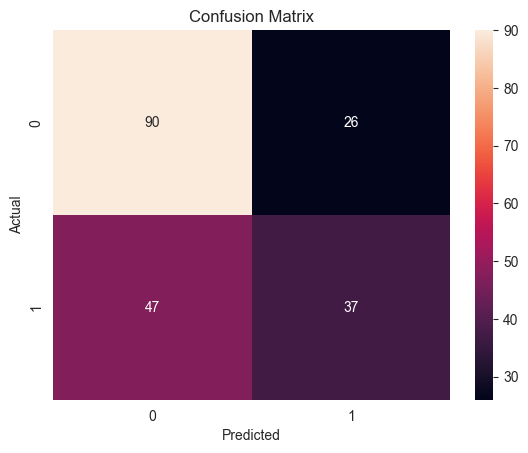

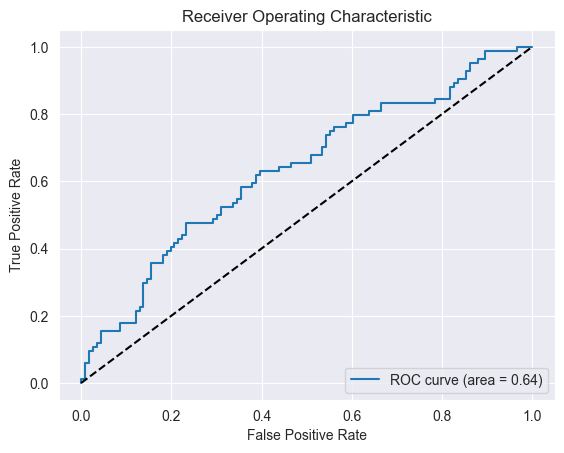

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

## 7. Save Model to Disk

Persist the trained model to disk using joblib for later use.

In [9]:
import joblib

# Save model and scaler
joblib.dump(model, 'src/readmission_model.joblib')
scaler = StandardScaler().fit(X_train)
joblib.dump(scaler, 'src/scaler.joblib')
print('Model and scaler saved.')

Model and scaler saved.
